In [ ]:
# ======================================================
# Step 1: Setup (Mount Drive, Install packages)
# ======================================================
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision timm scikit-learn tqdm

# ======================================================
# Step 2: Unzip your dataset into /content/
# ======================================================
!rm -rf /content/DATA
!unzip -oq "/content/drive/MyDrive/LYProject/SkinCondition.zip" -d "/content/"

# Check dataset structure
!ls /content/DATA
!ls /content/DATA/train

Mounted at /content/drive
test  train  val
 acne   Eczema	 Psoriasis  'Tinea Ringworm'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1/30


/tmp/ipython-input-1273682769.py:77: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipython-input-1273682769.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Loss: 0.8196 Acc: 0.6228
Val Loss: 0.7716 Acc: 0.6389
Epoch 2/30
Train Loss: 0.5888 Acc: 0.7381
Val Loss: 0.6212 Acc: 0.7312
Epoch 3/30
Train Loss: 0.4900 Acc: 0.7989
Val Loss: 0.5671 Acc: 0.7637
Epoch 4/30
Train Loss: 0.4285 Acc: 0.8252
Val Loss: 0.5476 Acc: 0.7911
Epoch 5/30
Train Loss: 0.3769 Acc: 0.8571
Val Loss: 0.5015 Acc: 0.7961
Epoch 6/30
Train Loss: 0.3028 Acc: 0.8849
Val Loss: 0.4914 Acc: 0.8245
Epoch 7/30
Train Loss: 0.2808 Acc: 0.8938
Val Loss: 0.4581 Acc: 0.8245
Epoch 8/30
Train Loss: 0.2320 Acc: 0.9136
Val Loss: 0.4908 Acc: 0.8215
Epoch 9/30
Train Loss: 0.2170 Acc: 0.9177
Val Loss: 0.4878 Acc: 0.8235
Epoch 10/30
Train Loss: 0.1951 Acc: 0.9296
Val Loss: 0.4840 Acc: 0.8286
Epoch 11/30
Train Loss: 0.1624 Acc: 0.9425
Val Loss: 0.4510 Acc: 0.8428
Epoch 12/30
Train Loss: 0.1425 Acc: 0.9492
Val Loss: 0.4445 Acc: 0.8479
Epoch 13/30
Train Loss: 0.1274 Acc: 0.9579
Val Loss: 0.4662 Acc: 0.8408
Epoch 14/30
Train Loss: 0.1194 Acc: 0.9590
Val Loss: 0.4468 Acc: 0.8560
Epoch 15/30


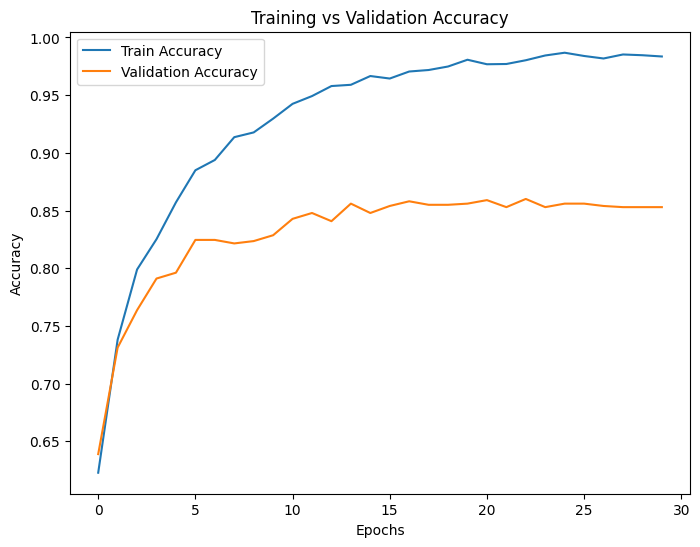

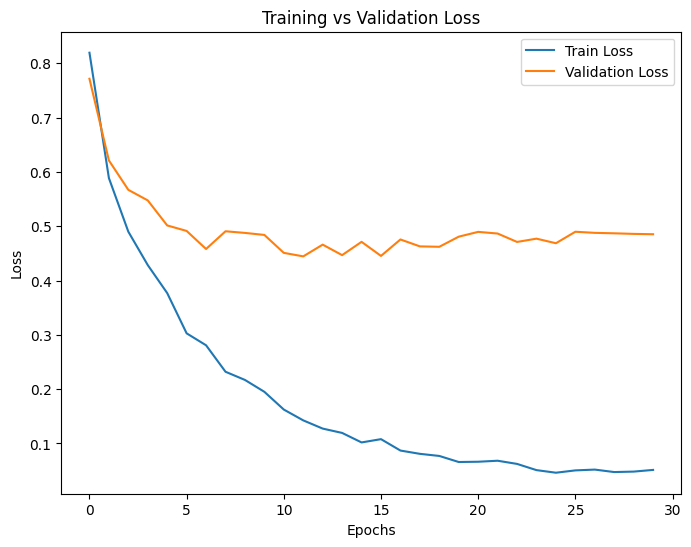

Classification Report:
                precision    recall  f1-score   support

        Eczema       0.85      0.79      0.82       253
     Psoriasis       0.82      0.86      0.84       309
Tinea Ringworm       0.85      0.86      0.85       256
          acne       1.00      1.00      1.00       173

      accuracy                           0.87       991
     macro avg       0.88      0.88      0.88       991
  weighted avg       0.87      0.87      0.87       991



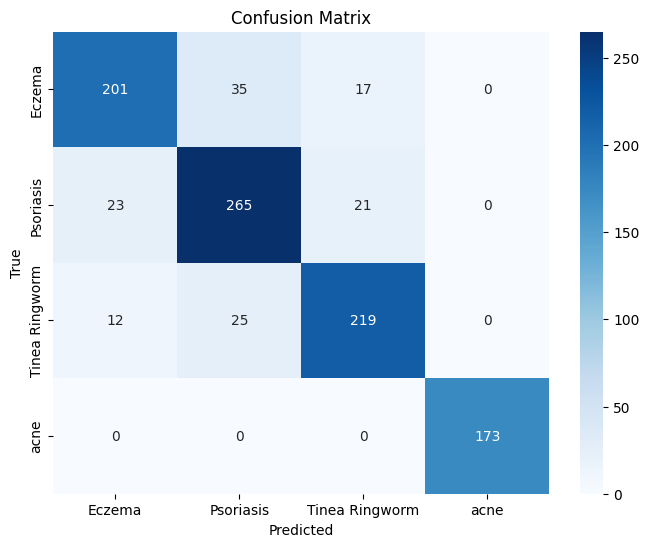

Test Accuracy: 86.58%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

# ======================================================
# Config
# ======================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/content/DATA"  # adjust to dataset path
batch_size = 16
num_epochs = 30
lr = 1e-5

# ======================================================
# Data Augmentation
# ======================================================
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1,0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# ======================================================
# Datasets & Loaders
# ======================================================
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transforms)

class_names = train_dataset.classes

# Balanced Sampler
class_counts = np.bincount([y for _, y in train_dataset.samples])
class_weights = 1. / class_counts
weights = [class_weights[y] for _, y in train_dataset.samples]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# ======================================================
# Swin Transformer Model
# ======================================================
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

# ======================================================
# Training Function
# ======================================================
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_acc = 0.0
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # -------- Training --------
        model.train()
        running_loss, running_corrects, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        history["train_loss"].append(epoch_loss)
        history["train_acc"].append(epoch_acc.item())

        # -------- Validation --------
        model.eval()
        val_loss, val_corrects, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_corrects.double() / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()

    model.load_state_dict(best_model_wts)
    return model, history

# ======================================================
# Train Model
# ======================================================
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

# ======================================================
# Training Curves
# ======================================================
plt.figure(figsize=(8,6))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

plt.figure(figsize=(8,6))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# ======================================================
# Test Evaluation
# ======================================================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc*100:.2f}%")
